In [1]:
import xgboost as xgb
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.metrics import f1_score

In [2]:
# open dfs
bact_f = pd.read_table('proteobacteria-f_fitch_g-b.txt')
bact_g = pd.read_table('proteobacteria-g_fitch_g-b.txt')
fun = pd.read_table('fungi_fitch_g-b.txt')
euk = pd.read_table('eukaryota_fitch_g-b.txt')
archaea = pd.read_table('archaea_fitch_g-b.txt')

# merging the training set
frames = [archaea, fun, euk]
train = pd.concat(frames)
test = bact_f

In [3]:
# Create a list of the feature column's names
features = train.columns[1:-1]
X_train = train[features].as_matrix()
X_test = test[features].as_matrix()

y_train = train['division'] == 'good'
y_test = test['division'] == 'good'

In [89]:
#xgboost classifier
#gbm = xgb.XGBClassifier(max_depth=3, n_estimators=100).fit(X_train, y_train)
#predictions = gbm.predict(X_test)

In [4]:
parameters = {'max_depth':[2,3,4], 'n_estimators':[100, 200, 300, 400, 500], 'gamma':[0.01, 0.05, 0.1]}

In [6]:
#Grid search

from sklearn.model_selection import GridSearchCV

xgb_model = xgb.XGBClassifier()
#brute force search
clf_gs = GridSearchCV(xgb_model, parameters)
clf_gs.fit(X_train, y_train)

best_parameters, score, _ = max(clf_gs.grid_scores_, key=lambda x: x[1])
print('Raw AUC score:', score)
for param_name in sorted(best_parameters.keys()):
    print("%s: %r" % (param_name, best_parameters[param_name]))



('Raw AUC score:', 0.83418013856812934)
gamma: 0.1
max_depth: 2
n_estimators: 100


C:\Users\Elena\PyMOL\envs\ipykernel_py2\lib\site-packages\sklearn\model_selection\_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


In [14]:
test_preds = clf_gs.predict(X_test)

#comparison to real classes
from sklearn.metrics import confusion_matrix
cm = pd.DataFrame(confusion_matrix(y_test, test_preds))
cm

,0,1
0,452,89
1,70,127


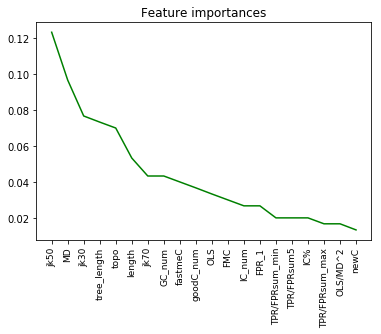

In [21]:
#plot feature importances
import matplotlib.pyplot as plt

importances = clf_gs.best_estimator_.feature_importances_
imp_genes = sorted(zip(map(lambda x: round(x, 4), importances), features), 
             reverse=True)[:20]
#draw the barplot
height = []
genes = []
x = range(20)
for i in imp_genes:
    height.append(i[0])
    genes.append(i[1])


plt.plot(height, color = "green")
plt.title("Feature importances")
plt.xticks(x, genes, rotation='vertical', fontsize = 9)
plt.show()

In [22]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

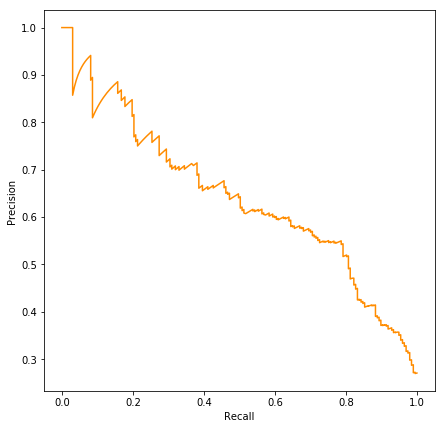

average precision score  0.642410496616


In [23]:
probabilities = pd.DataFrame(data = clf_gs.predict_proba(X_test))[1]
precision, recall, _ = precision_recall_curve(y_test, probabilities)

plt.figure(figsize = (7, 7))
plt.plot(recall, precision, color = 'darkorange')
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.show()

print "average precision score ", average_precision_score(y_test, probabilities)

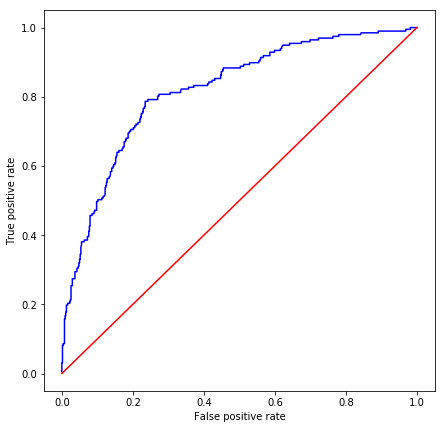

AUC:  0.818886814228


In [24]:
fpr, tpr, _ = roc_curve(y_test, probabilities)

plt.figure(figsize = (7, 7))
plt.plot(fpr, tpr, color = 'blue')
plt.plot([0, 1], [0, 1], color = 'red')
plt.xlabel("False positive rate")
plt.ylabel("True positive rate")
plt.show()

print "AUC: ", roc_auc_score(y_test, probabilities)